In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import Tensor
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

from google.colab import drive
from torchvision import datasets
from torchvision import transforms
from torchvision import transforms, utils

import torchvision

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/drive')#drive.mount('/content/drive')

Mounted at /drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/drive')#drive.mount('/content/drive')
DATA_DIR = '/drive/MyDrive/Dataset_Food/'#DATA_DIR = '/content/drive/MyDrive/Food/'


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [ ]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1:
            raise ValueError("BasicBlock only supports groups=1")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity # остаточное соединение
        out = self.relu(out)

        return out

In [ ]:
class Bottleneck(nn.Module):

    contraction: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = inplanes // self.contraction
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes)
        self.bn3 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        self.groups = groups
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)# тут 512 так как у последнего блока количество вых. каналов 512, после nn.AdaptiveAvgPool2d((1, 1)) разм. будет 512*1*1   ?

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )#можно другую создать

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.45),
        transforms.RandomRotation(10),
        transforms.RandomVerticalFlip(p=0.45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#,
        #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.1)#,  попробовать, если что- удалить #получилось так себе
        #transforms.RandomGrayscale(p=0.1) попробовать, если что- удалить
        # это аугментации для лучшего распознавания изображений при  разной освещенности и цветовой палитры
    ])

val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
train_dir = DATA_DIR + 'train'
val_dir = DATA_DIR + 'val'

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

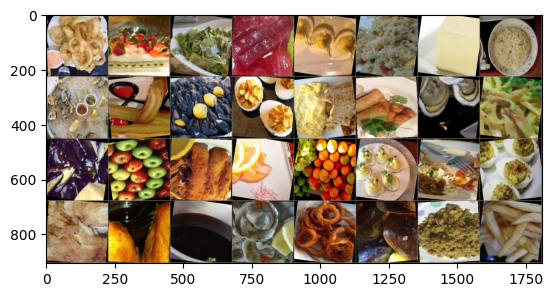

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):   #num_epochs=25
    best_loss = np.inf
    best_acc = 0
    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []
    labels_list=[]##
    pred_list=[]##
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_acc = 0.0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                ####
                if phase=='val':
                  labels_list.append(labels)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = outputs.argmax(dim=1)
                    loss = criterion(outputs, labels)
                    ######
                    if phase=='val':
                        pred_list.append(preds)
                        ######
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_acc += (preds == labels.data).float().mean()
            if phase == 'train':
                #scheduler.step()
                scheduler.step(loss)

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                loss_train.append(epoch_loss)
                acc_train.append(epoch_acc)

            if phase == 'val':
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                torch.save(model,f'{DATA_DIR}bestModel.pt')

        print()

    print(f'Best val Acc: {best_acc:4f}')

    return model, loss_train, acc_train, loss_val, acc_val,labels_list,pred_list

In [ ]:
model_ft = ResNet(BasicBlock, [3, 4, 4, 2], num_classes=7)#[3, 4, 3, 2]
model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.AdamW(model_ft.parameters(), lr=1e-3)#Adam
#########
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.8, patience=5)

##########3
#exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.9)

In [ ]:
device

device(type='cuda')

In [ ]:
model_ft, loss_train, acc_train, loss_val, acc_val,test_labels,test_preds = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=15)#20

Epoch 0/14
train Loss: 1.6483 Acc: 0.3877
val Loss: 2.1659 Acc: 0.2975

Epoch 1/14
train Loss: 1.5024 Acc: 0.4291
val Loss: 1.4851 Acc: 0.4428

Epoch 2/14
train Loss: 1.4117 Acc: 0.4744
val Loss: 1.7763 Acc: 0.5116

Epoch 3/14
train Loss: 1.4357 Acc: 0.4702
val Loss: 1.6548 Acc: 0.4231

Epoch 4/14
train Loss: 1.3909 Acc: 0.4772
val Loss: 1.3006 Acc: 0.5230

Epoch 5/14
train Loss: 1.3660 Acc: 0.4939
val Loss: 1.2745 Acc: 0.5141

Epoch 6/14
train Loss: 1.3309 Acc: 0.4926
val Loss: 1.1537 Acc: 0.5976

Epoch 7/14
train Loss: 1.3216 Acc: 0.5087
val Loss: 1.2007 Acc: 0.5704

Epoch 8/14
train Loss: 1.2839 Acc: 0.5264
val Loss: 1.1658 Acc: 0.5780

Epoch 9/14
train Loss: 1.2714 Acc: 0.5226
val Loss: 1.3036 Acc: 0.5406

Epoch 10/14
train Loss: 1.2566 Acc: 0.5303
val Loss: 1.1804 Acc: 0.5717

Epoch 11/14
train Loss: 1.2389 Acc: 0.5347
val Loss: 1.3243 Acc: 0.5758

Epoch 12/14
train Loss: 1.2217 Acc: 0.5555
val Loss: 1.1397 Acc: 0.6068

Epoch 13/14
train Loss: 1.1916 Acc: 0.5564
val Loss: 1.2365 A

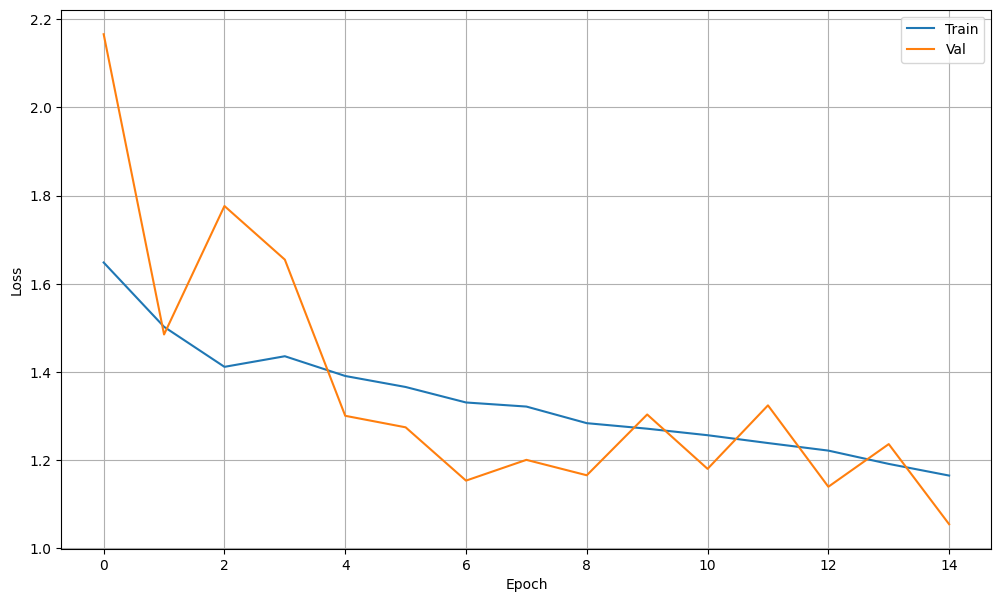

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(loss_train, label="Train")
plt.plot(loss_val,label="Val")
plt.grid()
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

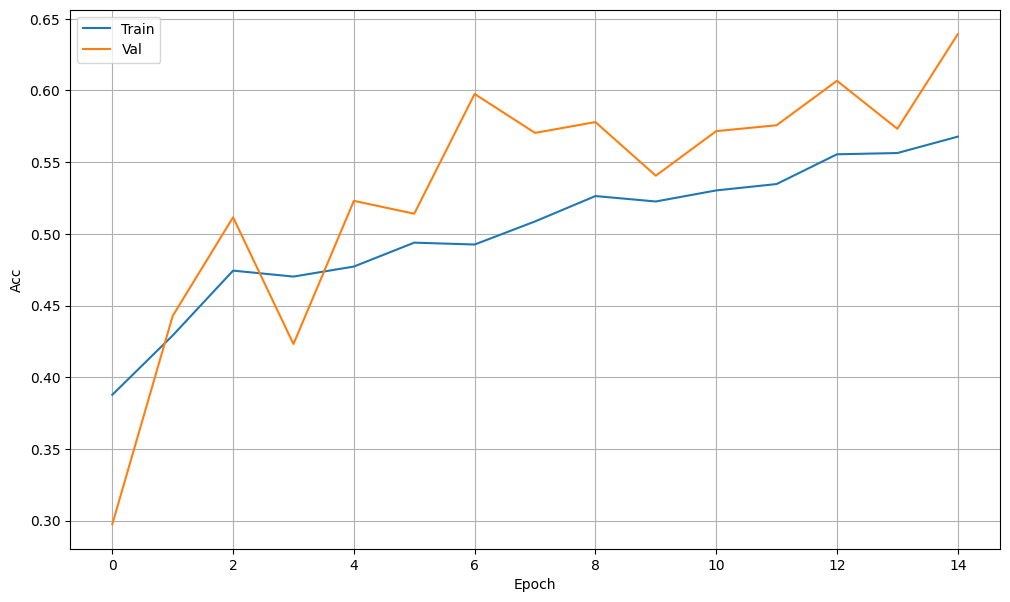

In [ ]:
val_acc = [x.cpu().numpy() for x in acc_val]
train_acc = [x.cpu().numpy() for x in acc_train]

plt.figure(figsize=(12, 7))
plt.plot(train_acc, label="Train")
plt.plot(val_acc ,label="Val")
plt.grid()
plt.legend()
plt.ylabel("Acc")
plt.xlabel("Epoch")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
class_names = train_dataset.classes
print(class_names)

['Dairy product', 'Egg', 'Fried food', 'Noodles-Pasta', 'Rice', 'Seafood', 'Vegetable-Fruit']


In [ ]:
if isinstance(test_labels, list) and len(test_labels) > 0 and isinstance(test_labels[0], torch.Tensor):

    test_labels_tensor = torch.cat(test_labels)

    test_labels_np = test_labels_tensor.cpu().numpy()
#else:

#    test_labels_np = np.array(test_labels)

if isinstance(test_preds, list) and len(test_preds) > 0 and isinstance(test_preds[0], torch.Tensor):

    test_preds_tensor = torch.cat(test_preds) #так как результат в виде тензора для каждого батча

    test_preds_np = test_preds_tensor.cpu().numpy()
#else:

 #   test_preds_np = np.array(test_preds)


cm = confusion_matrix(test_labels_np, test_preds_np)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 861  673  253   59   31  237   46]
 [ 382 2776  624  488   65  357  213]
 [ 137  883 2727  698   29  270  146]
 [  19  326  220 1372  126   80   62]
 [ 103  206   71  756  207   44   53]
 [ 184  988  567  192   34 2585  655]
 [  43  424  138  241   22  287 2325]]


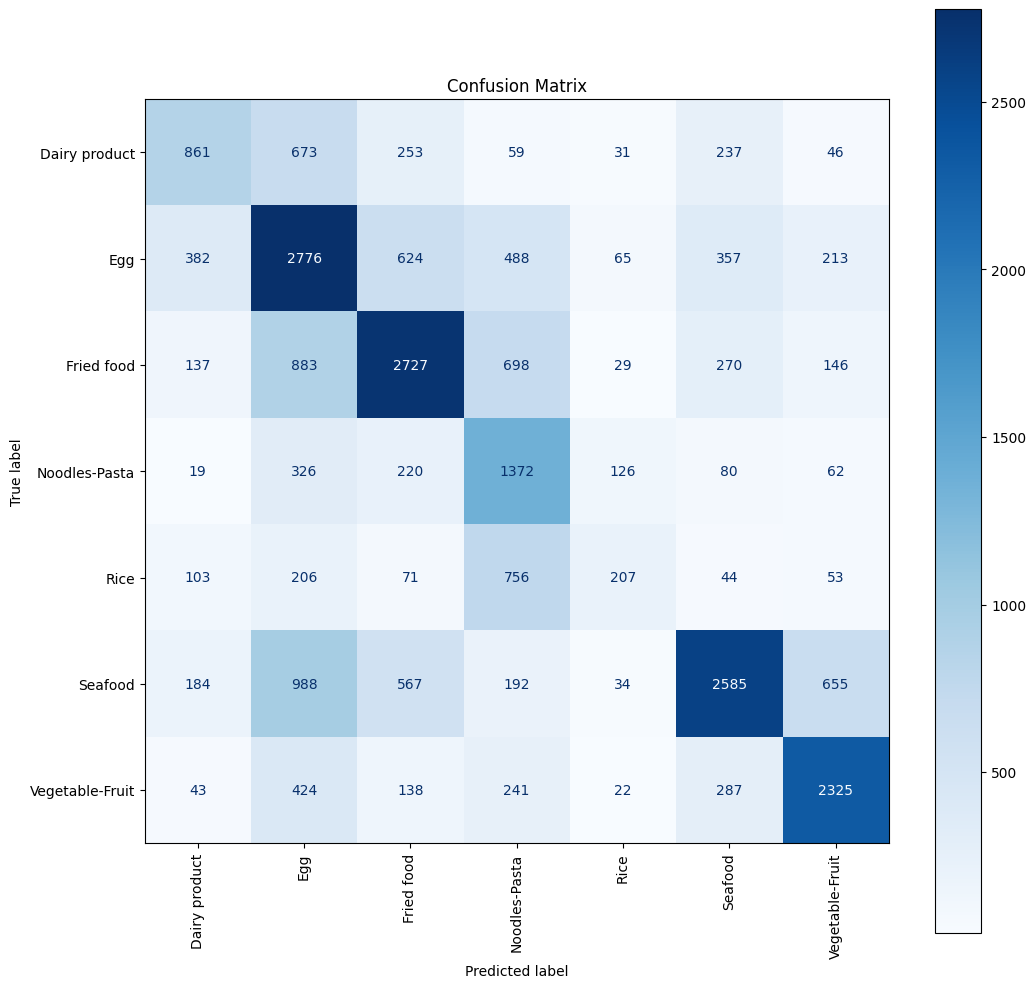

In [ ]:


# Визуализация confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names )
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

{'Dairy product': 0, 'Egg': 1, 'Fried food': 2, 'Noodles-Pasta': 3, 'Rice': 4, 'Seafood': 5, 'Vegetable-Fruit': 6}


In [ ]:
class_names = train_dataset.classes
print(class_names)

['Dairy product', 'Egg', 'Fried food', 'Noodles-Pasta', 'Rice', 'Seafood', 'Vegetable-Fruit']


In [ ]:

def view_specific_image(test_loader, img_idx, model, class_names, device):
    test_iter = iter(test_loader)
    for i in range(img_idx + 1):
        try:
            inputs, labels = next(test_iter)
        except StopIteration:
            raise IndexError("Индекс превышает размер test_loader")

    image = inputs[img_idx]
    label = labels[img_idx]

    image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)

    imshow(inputs[img_idx])
    print(f"Истинный класс: {class_names[label]} \nПредсказанный класс: {class_names[pred.item()]}")


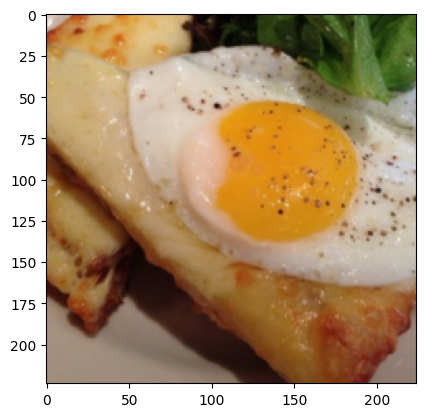

Истинный класс: Egg 
Предсказанный класс: Egg


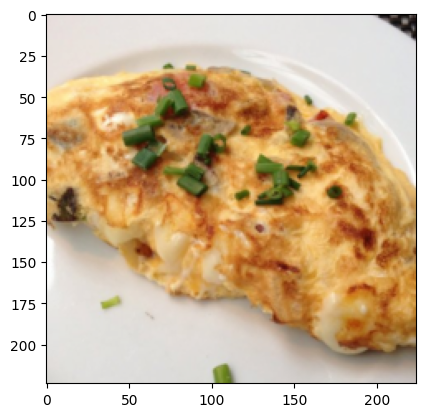

Истинный класс: Egg 
Предсказанный класс: Egg


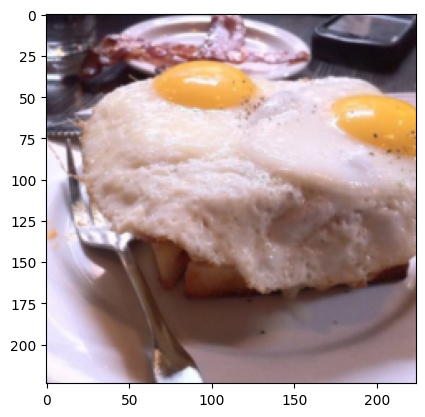

Истинный класс: Egg 
Предсказанный класс: Dairy product


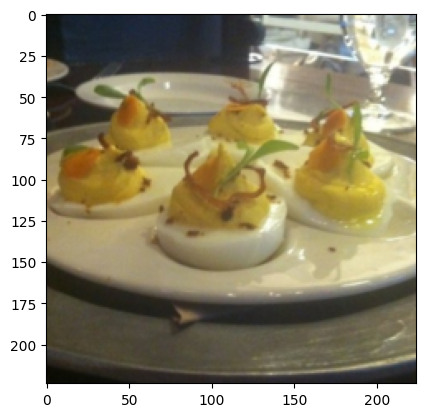

Истинный класс: Egg 
Предсказанный класс: Fried food


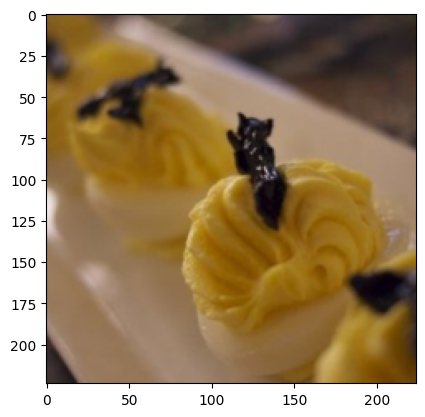

Истинный класс: Egg 
Предсказанный класс: Fried food


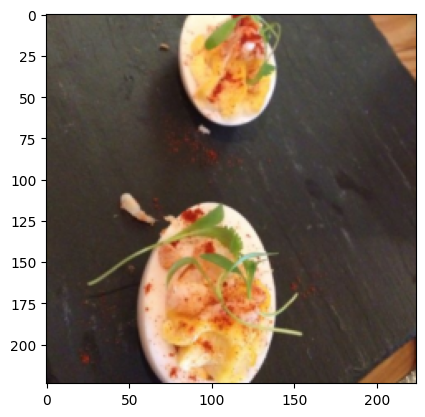

Истинный класс: Egg 
Предсказанный класс: Seafood


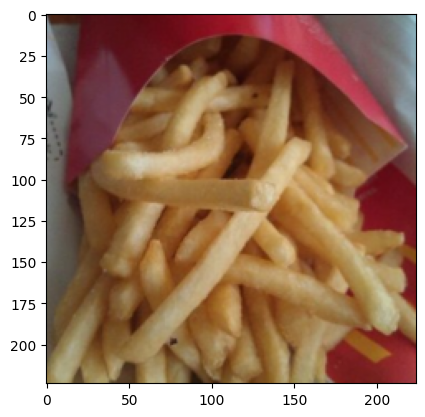

Истинный класс: Fried food 
Предсказанный класс: Fried food


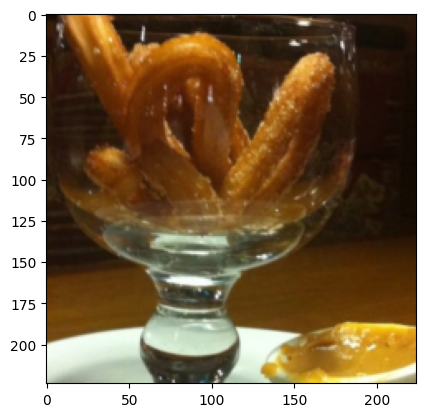

Истинный класс: Fried food 
Предсказанный класс: Fried food


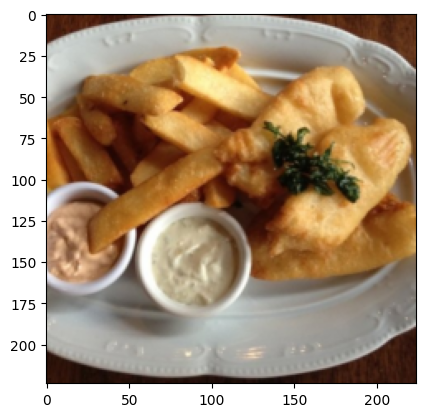

Истинный класс: Fried food 
Предсказанный класс: Fried food


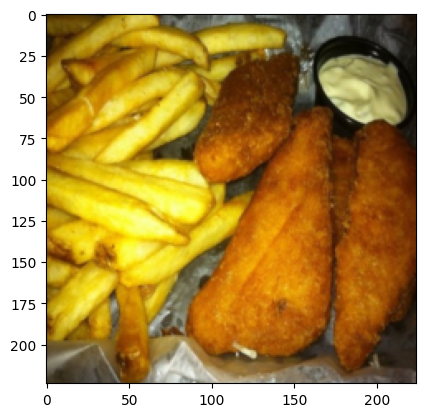

Истинный класс: Fried food 
Предсказанный класс: Fried food


In [ ]:
for i in range(9,19):
  view_specific_image(val_dataloader, img_idx=i, model=model_ft, class_names=class_names, device=device)

In [ ]:
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

{'Dairy product': 0, 'Egg': 1, 'Fried food': 2, 'Noodles-Pasta': 3, 'Rice': 4, 'Seafood': 5, 'Vegetable-Fruit': 6}


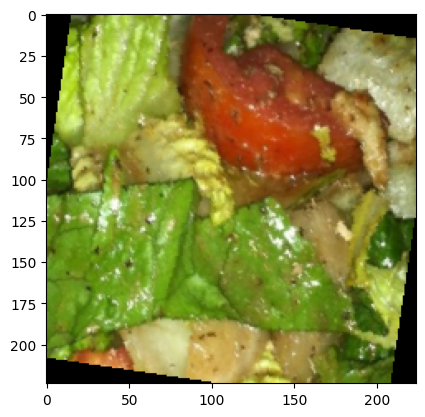

Истинный класс: Vegetable-Fruit 
Предсказанный класс: Vegetable-Fruit


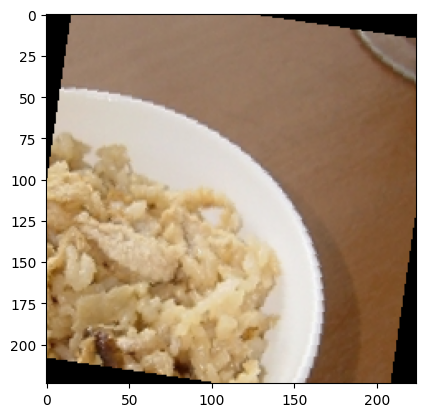

Истинный класс: Rice 
Предсказанный класс: Egg


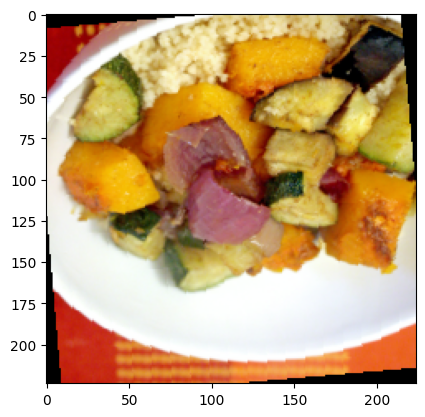

Истинный класс: Vegetable-Fruit 
Предсказанный класс: Egg


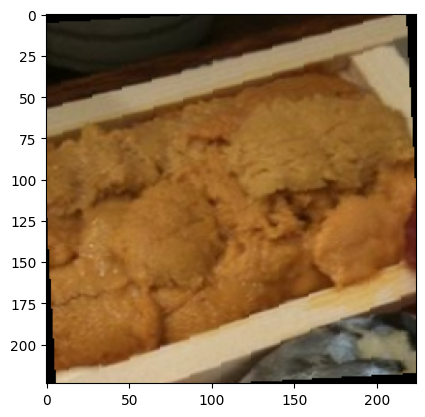

Истинный класс: Seafood 
Предсказанный класс: Fried food


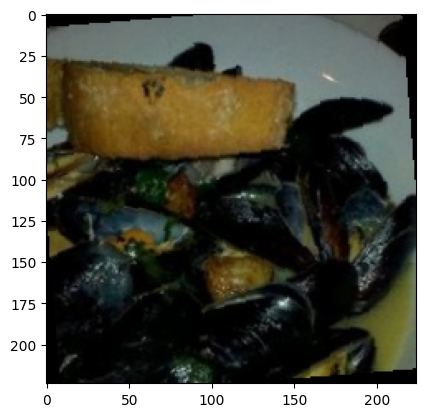

Истинный класс: Seafood 
Предсказанный класс: Seafood


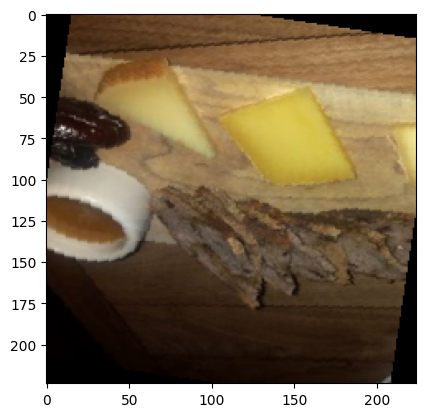

Истинный класс: Dairy product 
Предсказанный класс: Seafood


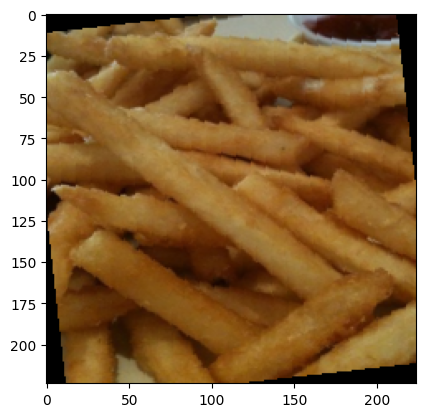

Истинный класс: Fried food 
Предсказанный класс: Fried food


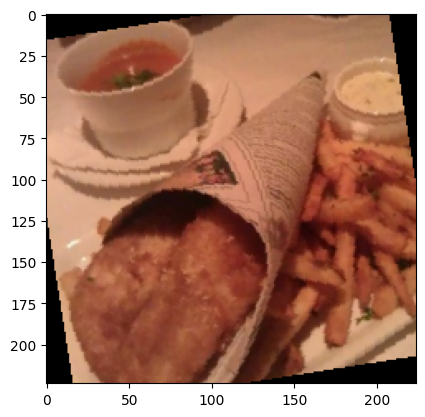

Истинный класс: Fried food 
Предсказанный класс: Fried food


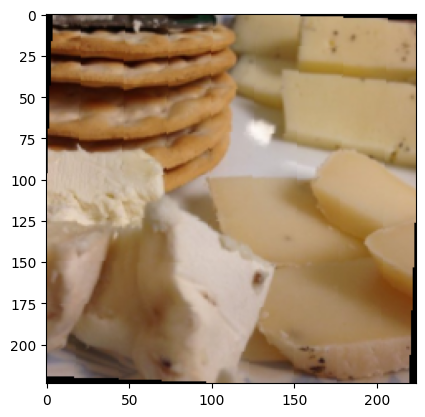

Истинный класс: Dairy product 
Предсказанный класс: Dairy product


In [ ]:
#идентично верхним примерам
for i in range(1,10):
  view_specific_image(train_dataloader, img_idx=i, model=model_ft, class_names=class_names, device=device)